# Robust Random Cut Forest

На основе примеров с официального сайта https://klabum.github.io/rrcf/

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import rrcf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

Сгенерируем данные

In [2]:
X = sps.norm.rvs(size=(6, 2))
X

array([[-0.56581141, -1.61513608],
       [-0.14464821, -0.95194492],
       [-0.74024808,  0.15303157],
       [-1.123376  ,  1.78791703],
       [-1.01425804, -1.23295333],
       [ 0.56784401, -0.65061297]])

### Структура дерева

Полученное дерево можно проверить, просто вызвав объект экземпляра:

In [3]:
tree = rrcf.RCTree(X)
tree

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├──(0)
 │   │   │   └───+
 │   │   │       ├──(4)
 │   │   │       └──(1)
 │   │   └──(2)
 │   └──(3)
 └──(5)

Корень и характеристики этого узла &mdash; ось и значение, соответствующие проведенному делению

In [4]:
tree.root

Branch(q=0, p=0.48)

Левое и правое поддеревья

In [5]:
tree.root.l, tree.root.r

(Branch(q=1, p=1.63), Leaf(5))

Родительская вершина

In [6]:
tree.root.l.u

Branch(q=0, p=0.48)

Листья дерева

In [7]:
tree.leaves

{0: Leaf(0), 4: Leaf(4), 1: Leaf(1), 2: Leaf(2), 3: Leaf(3), 5: Leaf(5)}

Глубина листа в дереве и точки в нем

In [8]:
tree.leaves[0].d, tree.leaves[0].x

(4, array([-0.56581141, -1.61513608]))

Количество точек в листе и ограничивающий отрезок

In [9]:
tree.leaves[0].n, tree.leaves[0].b

(1, array([[-0.56581141, -1.61513608]]))

### Модификация деревьев


Деревья могут динамически обновляться по новым данным с помощью добавления точек.

Создадим пустое дерево и вставим 6 новых точек с помощью метода `insert_point`, где каждая точка является двумерным гауссовским случайным вектором).

Обратите внимание, что для каждой точки назначается уникальный индекс. В данном случае это целое число в диапазоне от 0 до 6; однако для него можно использовать любой хешируемый тип.

In [10]:
tree = rrcf.RCTree()

for i in range(6):
    x = sps.norm.rvs(size=2)
    tree.insert_point(x, index=i)
    
tree

─+
 ├───+
 │   ├───+
 │   │   ├──(0)
 │   │   └───+
 │   │       ├──(1)
 │   │       └──(2)
 │   └───+
 │       ├──(5)
 │       └──(4)
 └──(3)

Аналогично, точки могут быть удалены дерева с помощью метода `forget_point`, которому нужно передать индекс точки.

In [11]:
tree.forget_point(2)
tree

─+
 ├───+
 │   ├───+
 │   │   ├──(0)
 │   │   └──(1)
 │   └───+
 │       ├──(5)
 │       └──(4)
 └──(3)

### Аномальность

Построим деревья

In [12]:
X = sps.norm.rvs(size=(100, 2))
tree = rrcf.RCTree(X)

Создадим типичную и аномальную точки и добавим их в дерево

In [13]:
inlier = np.array([0, 0])
outlier = np.array([4, 4])

tree.insert_point(inlier, index='inlier')
tree.insert_point(outlier, index='outlier')

Leaf(outlier)

Посчитаем степень их аномальности

In [14]:
tree.codisp('inlier')

1.6666666666666667

In [15]:
tree.codisp('outlier')

27.0

Для выброса значение существенно выше.

### Вычисление аномальности для случайного леса

Сгенерируем данные

In [16]:
n = 1000
d = 2
num_outliers = 10

X = sps.norm.rvs(size=(n, d))
X[-num_outliers:, :] += 4

X

array([[-0.73859523, -1.3546611 ],
       [ 0.57511853, -0.75561569],
       [-0.01878775, -0.74050444],
       ...,
       [ 2.47328334,  2.41017419],
       [ 4.30046974,  4.02740757],
       [ 4.49794712,  3.98819537]])

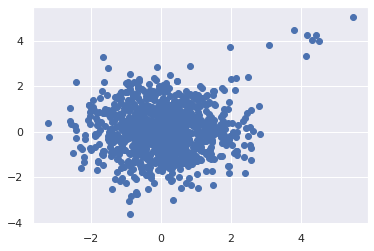

In [17]:
plt.scatter(X[:, 0], X[:, 1]);

Чтобы построить случайный лес, мы создаем список деревьев, причем каждое дерево строится из случайного подмножества данных. 

Построим случайный лес из 100 деревьев, каждое из которых содержит 128 точек из исходной выборки.

In [18]:
# строим лес
forest = []

num_trees = 100
tree_size = 128
sample_size_range = (n // tree_size, tree_size)

while len(forest) < num_trees:
    # выбираем случайные индексы точек
    ixs = np.random.choice(n, size=sample_size_range, replace=False)
    # добавляем дерево к лесу
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

Чтобы определить выбросы, мы вычисляем среднюю степень аномальности по всем деревьям для каждой точки в исходной выборке

In [19]:
avg_codisp = pd.Series(0.0, index=np.arange(n))  # степень аномальности
index = np.zeros(n)  # сколько раз точка встретилась в деревьях

for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)

avg_codisp /= index

Срденяя степень аномальности для типичных точек

In [20]:
avg_codisp[:-10].mean()

5.230716098915769

Средняя степень анормальности для выбросов

In [21]:
avg_codisp[-10:].mean()

34.35659738211524

Визуализируем степень аномальности

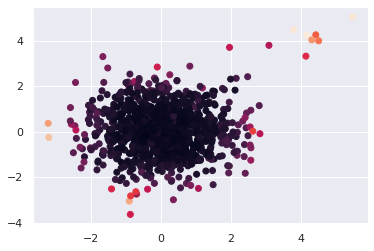

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=avg_codisp);

## Детектирование аномалий во временных рядах

Сгенерируем данные

In [23]:
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)

# нормальный ряд
sin = A*np.sin(T*(t-phi)) + center

# аномалия
sin[235:255] = 80

Посмотрим на график

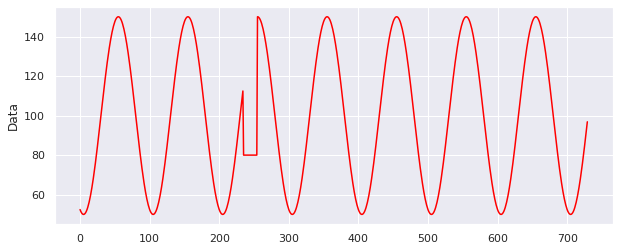

In [24]:
plt.subplots(figsize=(10, 4))
plt.plot(sin, color='red')
plt.ylabel('Data');

В качестве объектов для построения дерева будем использовать **принцип скользящего окна** &mdash; подряд идущие кусочки ряда по 4 измерения. То есть если $x_t$ &mdash; временной ряд, то первый объект для построения дерева имеет вид $(x_1, x_2, x_3, x_4)$, второй объект представим как $(x_2, x_3, x_4, x_5)$, и так далее.

Построим лес из пустых деревьев

In [37]:
num_trees = 40  # количество деревьев
shingle_size = 4  # размер окна (кол-во подряд идущих измерений)
tree_size = 256  # максимальное количество точек в дереве

# строим лес как список из пустых деревьев
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

Добавляем точки ряда по одной в дереьвя и считаем аномальность

In [38]:
# Генератор для создания потока окон-точек
points = rrcf.shingle(sin, size=shingle_size)

# Словарь степени аномальности каждой точки
avg_codisp = {}

# Для каждого окна
for index, point in enumerate(points):
    # для каждого дерева
    for tree in forest:
        # если дерево уже большое
        if len(tree.leaves) > tree_size:
            # удалим самую старую окно-точку
            tree.forget_point(index - tree_size)
        # добавим новую окно-точку
        tree.insert_point(point, index=index)
        # вычислим степень аномальности нового окна
        new_codisp = tree.codisp(index)
        # и усредним по всем деревьям
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

Визуализируем

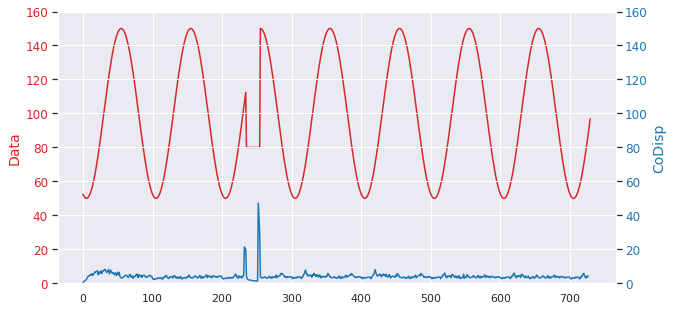

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Ряд данных
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)

# Ряд степени аномальности точек
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160);

Верхний ряд &mdash; исходный временной ряд, нижний &mdash; степень аномальности.